# <center>Daily Bucket Report </center>
- *by 홍석진, 이준혁*
---
> <span style = "color:gray"> 2022.04.25　:　초안 작성 </sapn> <br>
> <span style = "color:gray"> 2022.05.02　:　자동화 및 slack 전송 코드 작성 </sapn> <br>
> <span style = "color:red"> 2022.05.06　:　실험플랫폼 모듈화  </sapn> <br>
> <span style = "color:red">　　　　　　　ㄴ 준혁 : data input / MLS update </sapn>

---

### 000_Import Library

In [ ]:
#hsj

In [10]:
from sktmls.experiments.experiment import ExperimentClient

import pandas as pd

import numpy as np

import plotly.graph_objs as go

from scipy.stats import beta, bernoulli

In [113]:
pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [169]:
config = get_mls_config(env='prd', user='scm')
experiment_client = ExperimentClient(**config)
experiment_client

In [170]:
experiment_info = experiment_client.get_experiment(name = 'scm_reco_subsc_prod')
experiment_info

In [174]:
experiment_info.channels

In [171]:
channels_info = experiment_info.get()['channels']
channels_list = list(map(lambda x: x.get()['screen_id'], channels_info))
channels_list

['scm_reco_subsc_prod', 'scm_reco_subsc_prod_smp']

In [108]:
key = ['channel_id', 'bucket_name', 'dt']
key_ = ['channel_id', 'bucket_name']

In [109]:
stat = df.reset_index().sort_values(key).reset_index(drop=True).copy(deep=True)

In [110]:
stat['denominator_w7'] = stat.groupby(key_)['denominator'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())
stat['numerator_w7'] = stat.groupby(key_)['numerator'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())

stat['denominator_w14'] = stat.groupby(key_)['denominator'].transform(lambda x: x.rolling(window=14, min_periods=1, center=False).sum())
stat['numerator_w14'] = stat.groupby(key_)['numerator'].transform(lambda x: x.rolling(window=14, min_periods=1, center=False).sum())
#
# stat['click_cnt_w7'] = stat.groupby(key_)['click_cnt'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())
# stat['scrb_cnt_w7'] = stat.groupby(key_)['scrb_cnt'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())

In [111]:
stat['CTR_w7'] = stat['numerator_w7'] / stat['denominator_w7']
stat['CTR_w14'] = stat['numerator_w14'] / stat['denominator_w14']

In [29]:

class mls_thompson(ExperimentClient) :
    def __init__(self, env, runtime_env, username, password, experiment_name, base_ratio = 10) :
        self.env = env
        self.runtime_env = runtime_env
        self.username = username
        self.password = password
        self.experiment_name = experiment_name
        self.base_ratio = base_ratio
        
        print(self.experiment_name)
        super(mls_thompson, self).__init__(self.env, self.runtime_env, self.username, self.password)
        

        self.experiment = super().get_experiment(name=self.experiment_name)
        self.experiment_id = self.experiment.id
        self.experiment_name = self.experiment.name

        self.channel_info = self.experiment.get()['channels']
        self.channel_id_list = list(map(lambda x: x.get()['screen_id'], self.channel_info))
        self.channel_id_list_join = "'" + "','".join(self.channel_id_list) + "'"
        
        # self.list_buckets = super().list_buckets(self.list_buckets)
        self.list_buckets = super().list_buckets(self.experiment)
        
        self.bucket_id2name = {b.id : b.name for b in self.list_buckets}
        self.bucket_name2id = {b.name : b.id for b in self.list_buckets}

        from datetime import datetime, date, timedelta
        from dateutil.relativedelta import relativedelta
        self.TDAY = datetime.today()

        self.DT = self.TDAY.strftime("%Y-%m-%d")
        self.DT_NODASH = self.TDAY.strftime("%Y%m%d")

        self.BF_D1_DT = (self.TDAY - timedelta(days=1)).strftime("%Y-%m-%d")
        self.BF_D30_DT = (self.TDAY - timedelta(days=30)).strftime("%Y-%m-%d")
        self.BF_D90_DT = (self.TDAY - timedelta(days=90)).strftime("%Y-%m-%d")

        self.BF_D10_DT = (self.TDAY - timedelta(days=10)).strftime("%Y-%m-%d")
        self.BF_D10_DT_NODASH = (self.TDAY - timedelta(days=10)).strftime("%Y%m%d")

        
    # (1) 실험Client 정보 호출

    def get_experiment_info(self):
        return {"id" : self.experiment_id, "name" : self.experiment_name}

    def get_bucket_info(self):
        bucket_info = [{"id" : b.id, "name" : b.name, "created" : b.created_at.strftime('%Y%m%d'), "range" : b.bucket_range} for b in self.list_buckets]
        bucket_info = [dict(b, ratio=int(b["range"].split('~')[1]) - int(b["range"].split('~')[0]) + 1) for b in bucket_info]
        bucket_info = [b for b in sorted(bucket_info, key=lambda x: x['created'], reverse=False)]

        return bucket_info

        # (2) Thompson Sampling 실행

    def get_data_from_gcp(self):
        self.qry = f"""
            SELECT
                dt,
                channel_id,
                bucket_name,
                sum(impression_yn) as denominator,
                sum(click_yn) as numerator,
                sum(click_yn) / sum(impression_yn) * 100 as CTR
            FROM
                scm.mls_reco_conv_scrb_daily
            WHERE
                ci_api_distinct_idx = 1
                and impression_yn = 1
                
                and channel_id in ({self.channel_id_list_join})
            GROUP BY
                dt,
                channel_id,
                bucket_name
            ;
        """
        print(self.qry)
        self.df = bq_to_pandas(self.qry)
        self.df['dt'] = pd.to_datetime(self.df['dt'])
        self.df['channel_id'] = self.df['channel_id'].astype(str)
        self.df['bucket_name'] = self.df['bucket_name'].astype(str)
        
        self.key = ['channel_id', 'bucket_name', 'dt']
        self.key_ = ['channel_id', 'bucket_name']
        
        self.df = self.df.reset_index().sort_values(self.key).reset_index(drop=True).copy(deep=True)
        
        self.df['denominator_w7'] = self.df.groupby(self.key_)['denominator'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())
        self.df['numerator_w7'] = self.df.groupby(self.key_)['numerator'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())

        self.df['denominator_w14'] = self.df.groupby(self.key_)['denominator'].transform(lambda x: x.rolling(window=14, min_periods=1, center=False).sum())
        self.df['numerator_w14'] = self.df.groupby(self.key_)['numerator'].transform(lambda x: x.rolling(window=14, min_periods=1, center=False).sum())
        
        self.df['CTR_w7'] = self.df['numerator_w7'] / self.df['denominator_w7']
        self.df['CTR_w14'] = self.df['numerator_w14'] / self.df['denominator_w14']
        
        self.df = self.df.loc[self.df['dt'] == self.BF_D1_DT]
        return self.df

    def run_thompson(self):
       
        import pandas as pd
        self.df_result = dict(zip(['A', 'B', 'GA', 'Z'], [20, 15, 55, 10]))
        
        return self.df_result

    def report_thompson(self, df, slack_channel='#ep_report_test'):
        colors = ['rgba(207, 27, 30, .4)',
                  'rgba(15, 38, 214, .4)',
                  'rgba(10, 108, 94, .4)',
                  'rgba(147, 207, 27, .4)',
                  'rgba(10, 5, 0, .4)',
                  'rgba(117, 15, 140, .4)']
        %matplotlib inline

        x = np.linspace(0.005,0.03,1000)

        for m in range(df.shape[0]):
            print('test1----------------------------- :')
            print(df.shape[0])
            
            s = 'self.trace' + str(m)
            print(s)
            a = df.loc[df.bucket_name == df.bucket_name.values[m]].numerator_w7
            b = df.loc[df.bucket_name == df.bucket_name.values[m]].denominator_w7-df.loc[df.bucket_name == df.bucket_name.values[m]].numerator_w7

            y = beta.pdf(x, 1 + a, 1 + b)
            y /= y.max() ## normalize

            exec(s + f""" = go.Scatter(x=x,
                            y=y,
                            name='Bucket {df.bucket_name.values[m]}',
                            marker = dict(color=('rgba(10, 108, 94, 1)')),
                            fill='tozeroy',
                            fillcolor = '""" + colors[m] + f"""')""")

        fig = go.Figure([self.trace0, self.trace1, self.trace2, self.trace3])
        fig.update_layout(
        # title='Beta Distributions for Buckets',
        xaxis={'title': 'Possible CTR values'},
        yaxis={'title': 'Probability Density'},
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ))
        # fig.savefig("./temp/result_2.png")
        fig.show()
        fig.write_image(f"./temp/result_{self.env}_{self.experiment_name}_1.png", height = 300) 

        import matplotlib.pyplot as plt

        data = df
        header_columns=0
        col_width=2.0
        row_height=0.625
        font_size=14
        header_color='#40466e'
        row_colors=['#f1f1f2', 'w']
        edge_color='w'
        bbox=[0, 0, 1, 1]
        ax=None

        if ax is None:
            size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
            fig, ax = plt.subplots(figsize=size)
            ax.axis('off')
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns)
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)

        for k, cell in mpl_table._cells.items():
            cell.set_edgecolor(edge_color)
            if k[0] == 0 or k[1] < header_columns:
                cell.set_text_props(weight='bold', color='w')
                cell.set_facecolor(header_color)
            else:
                cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
        
        fig = ax.get_figure()


        fig.savefig(f"./temp/result_{self.env}_{self.experiment_name}_2.png")

        
        # Slack package
        from slack_sdk import WebClient
        from slack_sdk.errors import SlackApiError
        from skt.vault_utils import get_secrets
        token = get_secrets("slack")["bot_token"]["airflow"]
        proxy = get_secrets("proxy")["proxy"]
        proxies = {
            "http": proxy,
            "https": proxy,
        }
        headers = {
            "Content-Type": "application/json;charset=utf-8",
            "Authorization": f"Bearer {token}",
        }

        client = WebClient(token=token, proxy=proxy)

        #---------------------------------------------------------------------------#
        ##### TITLE
        response = client.files_upload(file= "./temp/bucket_v5.png",
                                       channels = '#ep_report_test',
                                       initial_comment = f""":calendar: *{self.BF_D1_DT}* ( today : {self.DT} )""",
                                          title = '　　　　　　　　　　　　　　　　　　　　Author : 홍석진, 이준혁')

        #---------------------------------------------------------------------------#
        # RESULT 1
        #---------------------------------------------------------------------------#
        response = client.files_upload(file= f"./temp/result_{self.env}_{self.experiment_name}_2.png",
                                       channels = slack_channel,
                                       initial_comment = f"""
        :bulb: 신규 Bucket 추가
        :bulb: Bucket Ratio 순위 변동
        """,
                                          title = 'Bucket별 Beta 분포')



        ##### RESULT 2
        response = client.files_upload(file= f"./temp/result_{self.env}_{self.experiment_name}_1.png",
                                       channels = slack_channel,
                                       initial_comment = f"""
        """,
                                          title = '일자별 Bucket별 Ratio')



# def get_daily_ctr(experiment_info):
#     """Calculates daily CTR of each buckets in the experiment.
#     Args:
#         experiment_info (dict): Experiment summary. Use output of the `desc_experiment` function.
#     Returns:
#         pd.DataFrame
#             Dataframe daily CTR info. Data columns are as follows:
#             ===================  ==============================================================
#             dt                   date (as `datetime`)
#             channel_id           MLS channel ID (as `str`)
#             bucket_name          MLS bucket name (as `str`)
#             denominator          impression count (as `int`)
#             numerator            click count (as `int`)
#             CTR                  Click-Through Rate
#             bucket_of_interest   1 if bucket is related to the MLFlow experiment, else 0
#             ===================  ==============================================================
#     """

#     channel_id_list = get_channels_from_experiment(experiment_info['연결실험이름'])
#     channel_id_list_join = "'" + "','".join(channel_id_list) + "'"
#     qry = f"""
#     SELECT
#       dt,
#       channel_id,
#       bucket_name,
#       sum(impression_yn) as denominator,
#       sum(click_yn) as numerator,
#       sum(click_yn) / sum(impression_yn) * 100 as CTR
#     FROM
#       scm.mls_reco_conv_scrb_daily
#     WHERE
#       ci_api_distinct_idx = 1
#       and impression_yn = 1
#       and dt >= '{experiment_info['실험시작일']}'
#       and channel_id in ({channel_id_list_join})
#     GROUP BY
#       dt,
#       channel_id,
#       bucket_name
#       ;
#       """
#     df = bq_to_pandas(qry)
#     df['dt'] = pd.to_datetime(df['dt'])
#     df['channel_id'] = df['channel_id'].astype(str)
#     df['bucket_name'] = df['bucket_name'].astype(str)
#     df['bucket_of_interest'] = np.where(df['bucket_name'] == experiment_info['연결버킷명'], 1, 0)
#     return df
        
#         def add_data(self, df, bucket_colname, success_colname, fail_colname):
#         # """
#         # 톰슨샘플링 실행할 때 입력될 수 있지만, 사전에 등록해서 데이터 검증 진행
#         # """
#             self.bucket_colname = bucket_colname
#             self.success_colname = success_colname
#             self.fail_colname = fail_colname

#             assert bucket_colname not in thompson_df, f"{bucket_colname}이 데이터에 존재하지 않습니다."
#             assert success_colname not in thompson_df, f"{success_colname}이 데이터에 존재하지 않습니다."
#             assert fail_colname not in thompson_df, f"{bufail_colnamecket_colname}이 데이터에 존재하지 않습니다."
#             self.thompson_df = df[[bucket_colname, success_colname, fail_colname]]

#             data_bucket = list(thompson_df[bucket_colname])
#             assert len(data_bucket) != len(set(data_bucket)), "버킷별 데이터가 단일하지 않습니다."

#         return self.thompson_df

#         def run_thompson(self, sample_size):
#             for bucket in self.bucket_name2id:
#                 if bucket in self.thompson_df[self.bucket_colname] :
#                     tmp = self.thompson_df[self.thompson_df[self.bucket_colname] == bucket].reset_index(drop=True)
#                     sucess =tmp[self.success_colname][0]
#                     fail =tmp[self.fail_colname][0]

#                     beta_rvs_probs = list(beta.rvs(success, fail, size=sample_size)
    
#                 else :
#                     print('')
                                


        # def report_thompson(self):




        # (3) Thompson Sampling 시뮬레이션

        # def add_data_simul(self, df, bucket_colname, success_colname, fail_colname, series_colname)



        # (4) 버킷 업데이트 및 MLS 결과 확인
        # def update_bucket


{'A': 20, 'B': 15, 'GA': 55, 'Z': 10}

'A'

In [3]:
from sktmls import MLSENV, MLSRuntimeENV, MLSClient, ModelRegistry
from sktmls.experiments.experiment import Experiment, ExperimentClient

In [11]:
from skt.gcp import bq_to_pandas

In [214]:
### STG
jhjh = mls_thompson(env=MLSENV.STG, 
                    runtime_env=MLSRuntimeENV.YE, 
                    username="scm", 
                    password="rnehrahebf", 
                    experiment_name = 'battleground_jhjh_test')

battleground_jhjh_test


In [30]:
### PRD
jhjh = mls_thompson(env=MLSENV.PRD, 
                    runtime_env=MLSRuntimeENV.YE, 
                    username="scm", 
                    password="rnehrahebf", 
                    experiment_name = 'scm_reco_subsc_prod')


scm_reco_subsc_prod


In [5]:
jhjh.get_experiment_info()

{'id': 262, 'name': 'scm_reco_subsc_prod'}

In [6]:
jhjh.get_bucket_info()

[{'id': 529, 'name': 'A', 'created': '20210723', 'range': '0~9', 'ratio': 10},
 {'id': 583,
  'name': 'Z',
  'created': '20210830',
  'range': '10~19',
  'ratio': 10},
 {'id': 588,
  'name': 'B',
  'created': '20211012',
  'range': '20~39',
  'ratio': 20},
 {'id': 600,
  'name': 'GA',
  'created': '20220325',
  'range': '40~99',
  'ratio': 60}]

In [12]:
dat = jhjh.get_data_from_gcp()


            SELECT
                dt,
                channel_id,
                bucket_name,
                sum(impression_yn) as denominator,
                sum(click_yn) as numerator,
                sum(click_yn) / sum(impression_yn) * 100 as CTR
            FROM
                scm.mls_reco_conv_scrb_daily
            WHERE
                ci_api_distinct_idx = 1
                and impression_yn = 1
                
                and channel_id in ('scm_reco_subsc_prod','scm_reco_subsc_prod_smp')
            GROUP BY
                dt,
                channel_id,
                bucket_name
            ;
        
unsupported operand type(s) for /: 'NoneType' and 'int'


Downloading: 100%|██████████| 721/721 [00:01<00:00, 426.73rows/s]
/opt/conda/lib/python3.8/site-packages/pyarrow/pandas_compat.py:787: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  index = _pandas_api.pd.RangeIndex(table.num_rows)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/_arrow_utils.py:9: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _pyarrow_version_ge_015 = LooseVersion(pyarrow.__version__) >= LooseVersion("0.15")


In [13]:
dat

,index,dt,channel_id,bucket_name,denominator,numerator,CTR,denominator_w7,numerator_w7,denominator_w14,numerator_w14,CTR_w7,CTR_w14
237,302,2022-05-08,scm_reco_subsc_prod,A,955,14,1.465969,9030.0,140.0,18069.0,266.0,0.015504,0.014721
434,686,2022-05-08,scm_reco_subsc_prod,B,1912,37,1.935146,18339.0,334.0,53715.0,956.0,0.018213,0.017798
476,425,2022-05-08,scm_reco_subsc_prod,GA,5765,151,2.619254,54666.0,1044.0,93211.0,1814.0,0.019098,0.019461
712,446,2022-05-08,scm_reco_subsc_prod,Z,1015,13,1.280788,9200.0,101.0,18321.0,195.0,0.010978,0.010644


In [8]:
result = jhjh.run_thompson()
result

{'A': 20, 'B': 15, 'GA': 55, 'Z': 10}

test1----------------------------- :
4
self.trace0
test1----------------------------- :
4
self.trace1
test1----------------------------- :
4
self.trace2
test1----------------------------- :
4
self.trace3


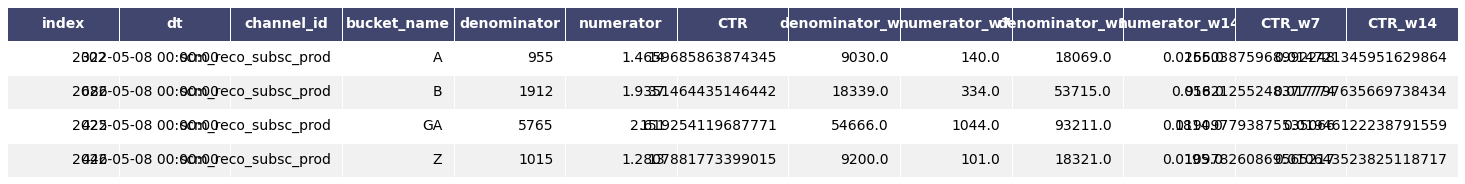

In [31]:
jhjh.report_thompson(df = dat)

,index,dt,channel_id,bucket_name,denominator,numerator,CTR,denominator_w7,numerator_w7,denominator_w14,numerator_w14,CTR_w7,CTR_w14
237,302,2022-05-08,scm_reco_subsc_prod,A,955,14,1.465969,9030.0,140.0,18069.0,266.0,0.015504,0.014721
434,686,2022-05-08,scm_reco_subsc_prod,B,1912,37,1.935146,18339.0,334.0,53715.0,956.0,0.018213,0.017798
476,425,2022-05-08,scm_reco_subsc_prod,GA,5765,151,2.619254,54666.0,1044.0,93211.0,1814.0,0.019098,0.019461
712,446,2022-05-08,scm_reco_subsc_prod,Z,1015,13,1.280788,9200.0,101.0,18321.0,195.0,0.010978,0.010644


In [50]:
result['ratio2'] = round(result['ratio']*(10*dat.shape[0]))

In [51]:
result

,bucket_name,ratio,ratio2
0,A,0.3,12.0
1,B,0.6,24.0
2,Z,0.1,4.0


In [57]:
dat0 = dat['bucket_name'].copy(deep=True).pd
dat0['base_ratio'] = 10

AttributeError: 'Series' object has no attribute 'pd'

In [56]:
dat0

237            A
434            B
476           GA
712            Z
base_ratio    10
Name: bucket_name, dtype: object

In [35]:
result2 = {'bucket_name' : list(result.bucket_name.values),
           'bucket_ratio' : list(result.ratio*(10*dat.shape[0]))}

In [36]:
result2

{'bucket_name': ['A', 'B', 'Z'], 'bucket_ratio': [12.0, 24.0, 4.0]}

In [40]:
dict(zip(list(result.bucket_name.values), list(result.ratio.values)))

{'A': 0.3, 'B': 0.6, 'Z': 0.1}

In [ ]:
data = {'dt' : jh_tdt,
        'no' : jh_i,
        'bucket_name': jh,
        'base': jh_r,
        'update_dt' : jh_udt}
data2 = pd.DataFrame(data)
print(data2)

data3 = {'bucket_name' : dat_jh.bucket_name,
         'bucket_ratio' : np.round(np.array(R)/sum(R)*(100-(10*len(my_bucket))))
        }
data4 = pd.DataFrame(data3)
print(data4)

4

In [14]:
for e in jhjh.list_buckets:
    print(e.name)

A
Z
B
GA


In [111]:
experiment_client = ExperimentClient(env=MLSENV.STG, 
                                     runtime_env=MLSRuntimeENV.YE, 
                                     username="scm", 
                                     password="rnehrahebf")

In [128]:
?experiment_client.list_buckets

Signature:
experiment_client.list_buckets(
    experiment: sktmls.experiments.experiment.Experiment,
    **kwargs,
) -> List[sktmls.experiments.experiment.Bucket]
Docstring:
특정 실험에 속한 버킷들의 정보를 조회합니다.

## Args

- experiment: (sktmls.experiments.Experiment) 버킷의 실험 객체
- kwargs: (optional) (dict) 쿼리 조건
    - id: (int) 버킷 고유 ID
    - name: (str) 버킷 이름
    - query: (str) 검색 문자
    - page: (int) 페이지 번호

## Returns
list(`sktmls.experiments.Bucket`)

- id: (int) 버킷 고유 ID
- experiment: (int) 버킷이 속한 실험정보
- prediction: (`sktmls.experiments.Prediction`) 해당 버킷의 Prediction 정보
- name: (str) 버킷 이름
- description: (str) 버킷 설명
- bucket_range: (str) 해당 버킷의 범위
- created_at: (datetime) 생성일시
- updated_at: (datetime) 수정일시

## Example

```python
buckets = experiment_client.list_buckets(experiment)
```
File:      /opt/conda/lib/python3.8/site-packages/sktmls/experiments/experiment.py
Type:      method


In [112]:
experiment_client.list_experiments()

In [ ]:
# origin workflow

In [ ]:
from sktmls.experiments.experiment import ExperimentClient # Bucket, Experiment, 

In [46]:
from sktmls import MLSENV, MLSRuntimeENV

from skt.mls import get_mls_config
config = get_mls_config(env='stg', user='scm')
config

# ?get_mls_config

{'env': <MLSENV.STG: 'stg'>,
 'username': 'scm',
 'password': 'rnehrahebf',
 'runtime_env': <MLSRuntimeENV.YE: 'YE'>}

In [27]:
experiment_client = ExperimentClient(**config)

In [101]:
experiments = experiment_client.list_experiments()
for e in experiments:
    print(e.name)

scm_edd_s3_test
scm_retention_subsc_prod
scm_survey_reco_a1_noupdate
scm_survey_option_a1_noupdate
scm_survey_clst_a1_noupdate
scm_reco_subsc_prod
scm_reco_subsc_prod_test
bts_reco_subsc_prod_test
bts_option_prod_test
scm_survey_option_a1_noupdate_random_test
scm_nosurvey_option_a1_noupdate
battleground_hoseong_test
battleground_eunjeong_test
battleground_sanghyun_test
battleground_jhjh_test
scm_reco_subsc_prod_offline_custom
scm_reco_subsc_prod_offline_org


In [28]:
target_experiment = 'battleground_jhjh_test'
target_experiment

'battleground_jhjh_test'

In [29]:
my_experiment = experiment_client.get_experiment(name=target_experiment)

In [30]:
my_experiment

In [37]:
my_experiment.updated_at

datetime.datetime(2022, 3, 8, 17, 21, 10, 902501, tzinfo=tzoffset(None, 32400))

In [ ]:
# get mls config

In [44]:
import concurrent.futures

In [42]:
env = 'dev'
user = 'scm'

In [45]:

configs = generate_configs(env=env, user=user)
configs

NameError: name 'generate_configs' is not defined

In [ ]:
e = concurrent.futures.ThreadPoolExecutor(max_workers=len(configs) + 1)
fs = [e.submit(check_client_config, conf) for conf in configs]
for f in concurrent.futures.as_completed(fs):
if f.exception() is None:
config = f.result()
break
e.shutdown(wait=False)
return config

In [85]:
####################################################
# dataframe 및 수치연산을 위한 library load
import pandas as pd
import numpy as np
import os
from datetime import datetime
####################################################
# 그래프를 그리기 위한 library 로드 (matplotlib / seaborn)
from matplotlib import pyplot as plt
import seaborn as sns # matplotlib 기반의 visualization library 
plt.style.use(['ggplot'])

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False
# NanumGothic 폰트가 안나오는 현상을 제거하기 위해 cache 업데이트
plt.rcParams["font.family"] = 'NanumGothic'
sns.set_style("darkgrid", {"font.family":['NanumGothicCoding']}) # 배경색 및 한글론트 설정
sns.set_palette("deep")
%matplotlib inline

####################################################
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from datetime import timedelta
pd.set_option('display.max_columns', 100)

from skt.gcp import bq_to_pandas, df_to_bq_table, bq_insert_overwrite 
from skt.gcp import get_bigquery_client, load_bigquery_ipython_magic
from skt.ye import slack_send

load_bigquery_ipython_magic()

In [86]:
# skt mls api 
import time
from skt.mls import get_mls_config, get_mls_component_client, get_mls_experiment_client
from skt.mls import get_mls_model_registry, get_mls_dimension_client, get_mls_ml_model_client, get_mls_profile_api_client

from sktmls import MLSENV, MLSRuntimeENV, MLSClient, ModelRegistry
from sktmls.filters.filter import FilterClient
from sktmls.datasets import DatasetClient, ProblemType, FeatureStoreConf, LabelDataConf
from sktmls.models import MLModelClient
from sktmls.ml_features import MLFeatureClient
from sktmls.experiments.experiment import Bucket, Experiment, ExperimentClient

In [87]:
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
TDAY = datetime.today()

DT = TDAY.strftime("%Y-%m-%d")
DT_NODASH = TDAY.strftime("%Y%m%d")

BF_D1_DT = (TDAY - timedelta(days=1)).strftime("%Y-%m-%d")
BF_D30_DT = (TDAY - timedelta(days=30)).strftime("%Y-%m-%d")
BF_D90_DT = (TDAY - timedelta(days=90)).strftime("%Y-%m-%d")

BF_D10_DT = (TDAY - timedelta(days=10)).strftime("%Y-%m-%d")
BF_D10_DT_NODASH = (TDAY - timedelta(days=10)).strftime("%Y%m%d")

print("DT : ", DT)
print("DT_NODASH : ", DT_NODASH)

print("BF_D1_DT : ", BF_D1_DT)
print("BF_D30_DT : ", BF_D30_DT)

print("BF_D10_DT : ", BF_D10_DT)
print("BF_D10_DT_NODASH : ", BF_D10_DT_NODASH)

DT :  2022-05-03
DT_NODASH :  20220503
BF_D1_DT :  2022-05-02
BF_D30_DT :  2022-04-03
BF_D10_DT :  2022-04-23
BF_D10_DT_NODASH :  20220423


<br><br>

### 001_기본 설정 

In [88]:
from sktmls import MLSENV, MLSRuntimeENV

from skt.mls import get_mls_config
config = get_mls_config(env='stg', user='scm')
config

{'env': <MLSENV.STG: 'stg'>,
 'username': 'scm',
 'password': 'rnehrahebf',
 'runtime_env': <MLSRuntimeENV.YE: 'YE'>}

In [89]:
experiment_client = ExperimentClient(**config)

<br><br>

### 002_내 실험 찾기, 그냥 입력해도 되고

In [90]:
experiments = experiment_client.list_experiments()

In [91]:
for e in experiments:
    print(e.name)

scm_edd_s3_test
scm_retention_subsc_prod
scm_survey_reco_a1_noupdate
scm_survey_option_a1_noupdate
scm_survey_clst_a1_noupdate
scm_reco_subsc_prod
scm_reco_subsc_prod_test
bts_reco_subsc_prod_test
bts_option_prod_test
scm_survey_option_a1_noupdate_random_test
scm_nosurvey_option_a1_noupdate
battleground_hoseong_test
battleground_eunjeong_test
battleground_sanghyun_test
battleground_jhjh_test
scm_reco_subsc_prod_offline_custom
scm_reco_subsc_prod_offline_org


In [92]:
target_experiment = experiments[-1].name
target_experiment

'scm_reco_subsc_prod_offline_org'

In [93]:
target_experiment = 'battleground_jhjh_test'
target_experiment

'battleground_jhjh_test'

<br><br>

### 002_실험 불러오기

In [94]:
my_experiment = experiment_client.get_experiment(name=target_experiment)

In [95]:
for e in dir(my_experiment):
    print(e)
    print

__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
__weakref__
bucketing_seed
channels
created_at
description
generate_request_body
get
id
model_filter
name
reset
updated_at
user


<br><br>

### 003_버킷 리스트 불러오기

In [96]:
my_bucket = experiment_client.list_buckets(
    experiment=my_experiment
)

In [97]:
print('--------------------------------------------------------')
for e in my_bucket:
    print('- 버킷명 : ' + e.name)
    print('- ID : ' + str(e.id))   
    print('- 버킷 비율 : ' + e.bucket_range + ' <--- 중요, 전체 100% 버킷중 비율 의미')    
    print('- 세부내용 : ' + str(e.description))    
    print('- 실험명 : ' + e.experiment.name) 
    print('--------------------------------------------------------')


--------------------------------------------------------
- 버킷명 : 00A
- ID : 783
- 버킷 비율 : 0~9 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : Auto-generated A bucket in battleground_jhjh_test
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : B
- ID : 784
- 버킷 비율 : 10~26 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : GA
- ID : 785
- 버킷 비율 : 27~79 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : Z
- ID : 794
- 버킷 비율 : 80~89 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : A
- ID : 795
- 버킷 비율 : 90~99 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------


In [98]:
my_bucket

<br><br>

### 999_Thompson Sampling 추가
---
- Thompson sampling을 적용하더라도, 각 bucket별 상한, 하한은 존재해야 할것이며,
  세부 항목은 우리가 정하겠지?

- 그 안에서 자동으로 Bucket Ratio를 조절하고, 그로 인한 실적 향상을 측정해보는 것에 의의가 있음
---
> **[ 예시 ]** <br><br>&nbsp;&nbsp;&nbsp;&nbsp;**<span style='color:red'>A (BTS v1)</span>**&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;**<span style='color:blue'>B (BTS v2)</span>**&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;**<span style='color:black'>Z (Random)</span>**<br><br>위와 같이 3개의 bucket이 있을때,<br>
  각각 70%, 20%, 10% 고정이 아닌 50%, 10%, 10%는 고정해둔 상태에서 <br>
  A와 B에 대하여 나머지 30%의 비율을 적절하게 배분하여 추천하는 방식을 채택한다면?


<br>

#### Beta 분포 업데이트를 위하여 일자별 버킷별 불러오기 ( w/ 실험 플랫폼 )

In [99]:
import os
os.system('mkdir -p battleground')
os.system('mkdir -p temp')

0

In [100]:
from skt.vault_utils import get_secrets
from skt.github_utils import GithubUtil
import io

path = f"https://github.com/sktaiflow/dag-advanced_analytics/blob/develop/experiment_platform/battleground/experiment"
files = [
        f'monitoring_report.py'
        ]

secrets = get_secrets('github/sktaiflow')
token = secrets['token']

proxies = {
    'http': secrets['proxy'],
    'https': secrets['proxy']
    }

g = GithubUtil(token, proxies=proxies)
for file in files:
    code = g.download_from_git(f"{path}/{file}").decode('utf-8')
    with open(f"battleground/{file}", "w+") as f:
        f.write(code)



In [101]:
from skt.gcp import bq_to_pandas
from skt.ye import slack_send
from datetime import datetime, date
from battleground.monitoring_report import desc_experiment, get_channels_from_experiment, get_daily_ctr, plot_performance, send_slack, update_experiment_end_dt, create_report

#### 우리가 테스트 하고자하는 실험의 어떤 버켓이던 상관없을듯. 
---
- 나는 우선 BTS V2를 예시로 선택
---

In [102]:
experiment_nm = '[exp001]galileo_single_reco_model'

In [103]:
experiment_info = desc_experiment(experiment_nm)

In [104]:
experiment_info

{'name': '구독단품추천_Galileo모델',
 '실험시작일': '2022-03-28',
 '담당자': 'hoseongy@sk.com',
 '종료조건': {'목표SampleSize': 15000},
 '연결실험이름': 'scm_reco_subsc_prod',
 '연결버킷명': 'GA'}

In [105]:
df = get_daily_ctr(experiment_info)

unsupported operand type(s) for /: 'NoneType' and 'int'


Downloading: 100%|██████████| 147/147 [00:01<00:00, 94.88rows/s] 


In [106]:
# from datetime import datetime
# df.dt.strftime("%V")

In [107]:
df.loc[df.dt <= '2022-04-01']

,dt,channel_id,bucket_name,denominator,numerator,CTR,bucket_of_interest
26,2022-03-30,scm_reco_subsc_prod,B,7907,141,1.783230,0
27,2022-03-30,scm_reco_subsc_prod,Z,1321,13,0.984103,0
45,2022-04-01,scm_reco_subsc_prod,GA,3658,82,2.241662,1
46,2022-04-01,scm_reco_subsc_prod,A,1932,26,1.345756,0
47,2022-03-28,scm_reco_subsc_prod,Z,887,10,1.127396,0
48,2022-03-29,scm_reco_subsc_prod,B,9773,203,2.077151,0
49,2022-03-29,scm_reco_subsc_prod,Z,1623,24,1.478743,0
50,2022-03-29,scm_reco_subsc_prod,GA,3430,84,2.448980,1
72,2022-03-30,scm_reco_subsc_prod,GA,2733,63,2.305159,1
73,2022-03-30,scm_reco_subsc_prod,A,1280,16,1.250000,0


In [108]:
key = ['channel_id', 'bucket_name', 'dt']
key_ = ['channel_id', 'bucket_name']

In [109]:
stat = df.reset_index().sort_values(key).reset_index(drop=True).copy(deep=True)

In [110]:
stat['denominator_w7'] = stat.groupby(key_)['denominator'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())
stat['numerator_w7'] = stat.groupby(key_)['numerator'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())

stat['denominator_w14'] = stat.groupby(key_)['denominator'].transform(lambda x: x.rolling(window=14, min_periods=1, center=False).sum())
stat['numerator_w14'] = stat.groupby(key_)['numerator'].transform(lambda x: x.rolling(window=14, min_periods=1, center=False).sum())
#
# stat['click_cnt_w7'] = stat.groupby(key_)['click_cnt'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())
# stat['scrb_cnt_w7'] = stat.groupby(key_)['scrb_cnt'].transform(lambda x: x.rolling(window=7, min_periods=1, center=False).sum())

In [111]:
stat['CTR_w7'] = stat['numerator_w7'] / stat['denominator_w7']
stat['CTR_w14'] = stat['numerator_w14'] / stat['denominator_w14']

In [112]:
import numpy as np
import pandas as pd
from scipy.stats import beta, bernoulli
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import random
import math

In [113]:
dat_jh = stat.loc[stat.dt == BF_D10_DT].copy(deep=True) #BF_D10_DT #BF_D1_DT

In [114]:
dat_jh

,index,dt,channel_id,bucket_name,denominator,numerator,CTR,bucket_of_interest,denominator_w7,numerator_w7,denominator_w14,numerator_w14,CTR_w7,CTR_w14
26,9,2022-04-23,scm_reco_subsc_prod,A,1141,21,1.840491,0,7446.0,123.0,14497.0,237.0,0.016519,0.016348
62,60,2022-04-23,scm_reco_subsc_prod,B,6983,114,1.632536,0,46009.0,905.0,88820.0,1856.0,0.019670,0.020896
98,8,2022-04-23,scm_reco_subsc_prod,GA,2303,45,1.953973,1,15394.0,325.0,29661.0,622.0,0.021112,0.020970
134,108,2022-04-23,scm_reco_subsc_prod,Z,1171,11,0.939368,0,7412.0,88.0,13208.0,175.0,0.011873,0.013250


In [115]:
ads = list(dat_jh.bucket_name)
ACTUAL_CTR = dict(zip(dat_jh.bucket_name, dat_jh.CTR))
ads_pass =list(dat_jh.denominator)
ads_fail =list(dat_jh.denominator - dat_jh.numerator)

R = [0 for i in range(len(ads))]


In [116]:
###new

for trial in range(10000):
    # print("\nTrial " + str(trial))

    rnd = np.random.RandomState()  # for machine payouts and Beta

    probs = []

    for m in range(len(ads)):
        # print(m)
        # probs[m] = rnd.beta(1 + ads_pass[m], 1 +  ads_fail[m])
        dat_jh['probs'] = rnd.beta(dat_jh['numerator_w7'], dat_jh['denominator_w7']-dat_jh['numerator_w7'])

    machine = np.argmax(dat_jh.probs)
    
    R[machine] += 1
    
    if trial%1000 == 0:
        print(trial)
        print(dat_jh.probs)
print("\nFinal Success vector: ", end="")
R


0
26     0.018147
62     0.019497
98     0.021533
134    0.014026
Name: probs, dtype: float64
1000
26     0.015078
62     0.019679
98     0.021595
134    0.011329
Name: probs, dtype: float64
2000
26     0.015324
62     0.020376
98     0.020856
134    0.010668
Name: probs, dtype: float64
3000
26     0.015939
62     0.018457
98     0.021494
134    0.011116
Name: probs, dtype: float64
4000
26     0.017551
62     0.018803
98     0.021259
134    0.012137
Name: probs, dtype: float64
5000
26     0.018745
62     0.020058
98     0.021560
134    0.010766
Name: probs, dtype: float64
6000
26     0.018478
62     0.019095
98     0.021225
134    0.012066
Name: probs, dtype: float64
7000
26     0.015547
62     0.019849
98     0.021133
134    0.011963
Name: probs, dtype: float64
8000
26     0.017134
62     0.019500
98     0.021509
134    0.012931
Name: probs, dtype: float64
9000
26     0.017443
62     0.018908
98     0.021681
134    0.011673
Name: probs, dtype: float64

Final Success vector: 

[61, 1337, 8602, 0]

In [223]:
TARGET_DT = BF_D10_DT

In [225]:
jh = []
jh_i = []
jh_r = []
jh_tdt = []
jh_udt = []
base = 10
target_dt = TARGET_DT
update_dt = DT
for i in range(len(my_bucket)):
    print(i)
    bucket_name_tmp = my_bucket[i].name
    print(bucket_name_tmp)
    
    jh_i += [i]
    jh += [bucket_name_tmp]
    jh_r += [base]
    jh_tdt += [target_dt]
    jh_udt += [update_dt]
    
print(jh)
print(jh_i)
print(jh_r)
print(jh_tdt)
print(jh_udt)

data = {'dt' : jh_tdt,
        'no' : jh_i,
        'bucket_name': jh,
        'base': jh_r,
        'update_dt' : jh_udt}
data2 = pd.DataFrame(data)
print(data2)

data3 = {'bucket_name' : dat_jh.bucket_name,
         'bucket_ratio' : np.round(np.array(R)/sum(R)*(100-(10*len(my_bucket))))
        }
data4 = pd.DataFrame(data3)
print(data4)

0
00A
1
B
2
GA
3
Z
4
A
['00A', 'B', 'GA', 'Z', 'A']
[0, 1, 2, 3, 4]
[10, 10, 10, 10, 10]
['2022-04-23', '2022-04-23', '2022-04-23', '2022-04-23', '2022-04-23']
['2022-05-03', '2022-05-03', '2022-05-03', '2022-05-03', '2022-05-03']
           dt  no bucket_name  base   update_dt
0  2022-04-23   0         00A    10  2022-05-03
1  2022-04-23   1           B    10  2022-05-03
2  2022-04-23   2          GA    10  2022-05-03
3  2022-04-23   3           Z    10  2022-05-03
4  2022-04-23   4           A    10  2022-05-03
    bucket_name  bucket_ratio
26            A           0.0
62            B           7.0
98           GA          43.0
134           Z           0.0


In [226]:
sample_size12 = pd.merge(left = data2 , right = data4, how = "left", on = "bucket_name")

In [227]:
sample_size12['bucket_ratio2'] = sample_size12['base'] + sample_size12['bucket_ratio'].fillna(0)
sample_size12['bucket_ratio2'] =  sample_size12['bucket_ratio2'].astype(int) 

In [228]:
sample_size12

,dt,no,bucket_name,base,update_dt,bucket_ratio,bucket_ratio2
0,2022-04-23,0,00A,10,2022-05-03,NaN,10
1,2022-04-23,1,B,10,2022-05-03,7.0,17
2,2022-04-23,2,GA,10,2022-05-03,43.0,53
3,2022-04-23,3,Z,10,2022-05-03,0.0,10
4,2022-04-23,4,A,10,2022-05-03,0.0,10


In [231]:
from skt.gcp import pandas_to_bq, pandas_to_bq_table
?pandas_to_bq_table

Signature:
pandas_to_bq_table(
    pd_df,
    dataset,
    table_name,
    partition=None,
    partition_field=None,
    clustering_fields=None,
    mode='overwrite',
)
Docstring: <no docstring>
File:      /opt/conda/lib/python3.8/site-packages/skt/gcp.py
Type:      function


In [232]:
pandas_to_bq_table(sample_size12, 'x1112055', 'battleground_report_ts_summary')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/03 15:54:07 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/utils.py:35: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/utils.py:57: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [236]:
bq = get_bigquery_client()
max_id = bq_to_pandas(f"SELECT * FROM x1112055.battleground_report_ts_summary")
# qry = f"""
# INSERT INTO x1112834.battleground_monitoring_summary(id, experiment_nm, slack_channel, experiment_end_dt)
# VALUES ({1 if pd.isnull(max_id) else max_id+1}, '{experiment_nm}', '{self.slack_channel}', '99991231')
# """
# result = bq.query(query=qry)
# print(result.result())

query: SELECT * FROM x1112055.battleground_report_ts_summary
destination: sktaic-datahub._404cd413a2f8f0159596b622607d99686554f38e.anon5d1ae90eaf49e80b10ee85c98e8196e9e854a6b5
total_rows: 5
slot_secs: 0.024



Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.36rows/s]


In [237]:
max_id

,dt,no,bucket_name,base,update_dt,bucket_ratio,bucket_ratio2
0,2022-04-23,0,00A,10,2022-05-03,NaN,10
1,2022-04-23,3,Z,10,2022-05-03,0.0,10
2,2022-04-23,4,A,10,2022-05-03,0.0,10
3,2022-04-23,1,B,10,2022-05-03,7.0,17
4,2022-04-23,2,GA,10,2022-05-03,43.0,53


In [121]:
my_bucket_ratio = dict(zip(my_bucket, sample_size12.bucket_ratio2))

In [122]:
bucket_list = []
for a in my_bucket:
    bucket_list += [a.name]
bucket_list

['00A', 'B', 'GA', 'Z', 'A']

In [123]:
if bucket_list == list(sample_size12.bucket_name):
    print('True')
else:
    prtin('Stop')

True


In [124]:
my_bucket_ratio

{<sktmls.experiments.experiment.Bucket at 0x7fb0061915e0>: 10,
 <sktmls.experiments.experiment.Bucket at 0x7fb00619b280>: 17,
 <sktmls.experiments.experiment.Bucket at 0x7fb0061959a0>: 53,
 <sktmls.experiments.experiment.Bucket at 0x7fb00619b8e0>: 10,
 <sktmls.experiments.experiment.Bucket at 0x7fb005730340>: 10}

In [42]:
# dat_jh.loc[dat_jh.bucket_name == ads[m]].numerator_w7
# dat_jh.loc[dat_jh.bucket_name == ads[m]].denominator_w7-dat_jh.loc[dat_jh.bucket_name == ads[m]].numerator_w7

In [125]:
colors = ['rgba(207, 27, 30, .4)',
'rgba(15, 38, 214, .4)',
'rgba(10, 108, 94, .4)',
'rgba(147, 207, 27, .4)',
'rgba(10, 5, 0, .4)',
'rgba(117, 15, 140, .4)']

In [45]:
# pip install -U kaleido

In [127]:
%matplotlib inline

A
26    123.0
Name: numerator_w7, dtype: float64
26    7323.0
dtype: float64
B
62    905.0
Name: numerator_w7, dtype: float64
62    45104.0
dtype: float64
GA
98    325.0
Name: numerator_w7, dtype: float64
98    15069.0
dtype: float64
Z
134    88.0
Name: numerator_w7, dtype: float64
134    7324.0
dtype: float64


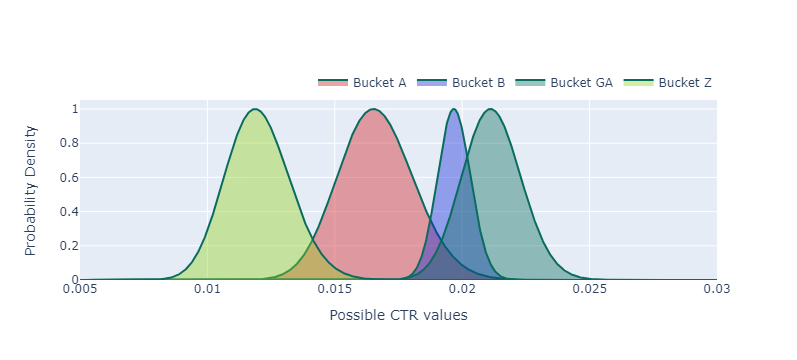

In [178]:
## plot the Beta distributions
x = np.linspace(0.005,0.03,1000)

 
# x = np.linspace(0.01,0.04,1000)

for m in range(len(ads)):
    
    s = 'trace' + str(m)
    print(ads[m])
    a = dat_jh.loc[dat_jh.bucket_name == ads[m]].numerator_w7
    b = dat_jh.loc[dat_jh.bucket_name == ads[m]].denominator_w7-dat_jh.loc[dat_jh.bucket_name == ads[m]].numerator_w7
    
    print(a)
    print(b)
    
    y = beta.pdf(x, 1 + a, 1 + b)

    y /= y.max() ## normalize

    exec(s + f""" = go.Scatter(x=x,
                        y=y,
                        name='Bucket {ads[m]}',
                        marker = dict(color=('rgba(10, 108, 94, 1)')),
                        fill='tozeroy',
                        fillcolor = '""" + colors[m] + f"""')""")

fig = go.Figure([trace0, trace1, trace2, trace3])
fig.update_layout(
    # title='Beta Distributions for Buckets',
    xaxis={'title': 'Possible CTR values'},
    yaxis={'title': 'Probability Density'},
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))


# fig.savefig("./temp/result_2.png")
fig.write_image("./temp/result_2.png", height = 300) 
fig.show()


In [ ]:
my_experiment

In [89]:
experiment_client.update_bucket_ratio(my_experiment, my_bucket_ratio)

In [90]:
my_bucket = experiment_client.list_buckets(
    experiment=my_experiment
)

In [91]:
print('--------------------------------------------------------')
for e in my_bucket:
    print('- 버킷명 : ' + e.name)
    print('- ID : ' + str(e.id))   
    print('- 버킷 비율 : ' + e.bucket_range + ' <--- 중요, 전체 100% 버킷중 비율 의미')    
    print('- 세부내용 : ' + str(e.description))    
    print('- 실험명 : ' + e.experiment.name) 
    print('--------------------------------------------------------')


--------------------------------------------------------
- 버킷명 : A
- ID : 783
- 버킷 비율 : 0~9 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : Auto-generated A bucket in battleground_jhjh_test
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : B
- ID : 784
- 버킷 비율 : 10~26 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : GA
- ID : 785
- 버킷 비율 : 27~79 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : Z
- ID : 794
- 버킷 비율 : 80~89 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------
- 버킷명 : TEST
- ID : 795
- 버킷 비율 : 90~99 <--- 중요, 전체 100% 버킷중 비율 의미
- 세부내용 : None
- 실험명 : battleground_jhjh_test
--------------------------------------------------------


# 저장 예시

In [244]:
dat_jh

,index,dt,channel_id,bucket_name,denominator,numerator,CTR,bucket_of_interest,denominator_w7,numerator_w7,denominator_w14,numerator_w14,CTR_w7,CTR_w14,probs
26,9,2022-04-23,scm_reco_subsc_prod,A,1141,21,1.840491,0,7446.0,123.0,14497.0,237.0,0.016519,0.016348,0.014952
62,60,2022-04-23,scm_reco_subsc_prod,B,6983,114,1.632536,0,46009.0,905.0,88820.0,1856.0,0.019670,0.020896,0.019943
98,8,2022-04-23,scm_reco_subsc_prod,GA,2303,45,1.953973,1,15394.0,325.0,29661.0,622.0,0.021112,0.020970,0.021445
134,108,2022-04-23,scm_reco_subsc_prod,Z,1171,11,0.939368,0,7412.0,88.0,13208.0,175.0,0.011873,0.013250,0.009919


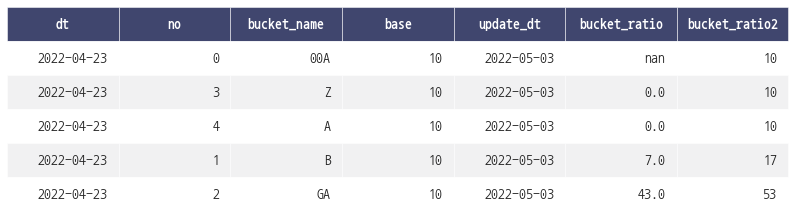

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(max_id, header_columns=0, col_width=2.0)
fig.savefig("./temp/result_1.png")

# Slack 전송

In [133]:

# Slack package
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

In [134]:
token = get_secrets("slack")["bot_token"]["airflow"]
proxy = get_secrets("proxy")["proxy"]
proxies = {
    "http": proxy,
    "https": proxy,
}
headers = {
    "Content-Type": "application/json;charset=utf-8",
    "Authorization": f"Bearer {token}",
}

In [135]:
client = WebClient(token=token, proxy=proxy)

In [136]:
import os
os.getcwd()

'/home/x1112055/Experiment_Platform/final_test/BUCKET_RATIO_AUTO'

In [202]:
datdat = stat.loc[(stat.dt >= BF_D10_DT) & (stat.channel_id =='scm_reco_subsc_prod')].copy(deep=True) #BF_D10_DT #BF_D1_DT

In [203]:
pd.DataFrame(ratio_series_adj1).plot(color=color_info)

NameError: name 'ratio_series_adj1' is not defined

In [216]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)

d = {'col1': [1, 2], 'col2': [3, 4], 'col3': ['a', 'b']}
df2 = pd.DataFrame(data=d)

d = {'col2': [30, 4], 'col3': ['a', 'b'], 'col1': [111111, 2]}
df3 = pd.DataFrame(data=d)

df12 = pd.concat([df,df2, df3])

In [218]:
pandas_to_bq_table(sample_size12, 'tos_auto_mkt', f'mthl_mkt_{chnl}_lchn_target_control_tbl')

bq_insert_overwrite(destination=f"sktaic-datahub.x1112055.battleground_report_ts_summary", sql=qry_2_0)

# bq = get_bigquery_client()
# qry = f"""
# create table x1112055.battleground_report_ts_summary

# """
# result = bq.query(query=qry)
# print(result.result())

BadRequest: 400 No column definitions in CREATE TABLE at [2:1]

Location: US
Job ID: 244a1768-fe9c-46e8-a4f8-5941c56b0eb6


In [ ]:
insert into  di_mi.mov_w_idx (home_loc_cd, home_loc_nm, age_cd, sex_cd, id_cnt, h0_mov_dist, h1_mov_dist, h0_max_h_dist, h1_max_h_dist, loc_type, yw) 
SELECT home_loc_cd, home_loc_nm, age_cd, sex_cd, id_cnt, h0_mov_dist, h1_mov_dist, h0_max_h_dist, h1_max_h_dist, loc_type, CAST(yw as INT64) as yw
FROM x1112055.mov_w_idx_nonpartition

In [ ]:
# table update hsh 
#----
# bq = get_bigquery_client()
#     qry = f"""
#     UPDATE x1112834.battleground_monitoring_summary SET experiment_end_dt = '{date.today().strftime('%Y%m%d')}' WHERE id = {id}
#     """
#     result = bq.query(query=qry)
#     print(result.result())

In [217]:
df12

,col1,col2,col3
0,1,3,NaN
1,2,4,NaN
0,1,3,a
1,2,4,b
0,111111,30,a
1,2,4,b


bucket_name
A     AxesSubplot(0.125,0.125;0.775x0.755)
B     AxesSubplot(0.125,0.125;0.775x0.755)
GA    AxesSubplot(0.125,0.125;0.775x0.755)
Z     AxesSubplot(0.125,0.125;0.775x0.755)
Name: CTR, dtype: object

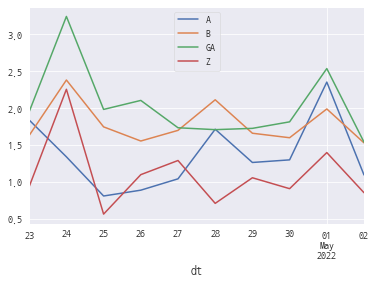

In [204]:
datdat.set_index('dt', inplace=True)
datdat.groupby('bucket_name')['CTR'].plot(legend=True)

# ㅇㅇㅇ

In [244]:
#---------------------------------------------------------------------------#
##### TITLE
response = client.files_upload(file= "./temp/bucket_v5.png",
                               channels = '#ep_report_test',
                               initial_comment = f""":calendar: *{BF_D10_DT}* ( today : {DT} )""",
                                  title = '　　　　　　　　　　　　　　　　　　　　Author : 홍석진, 이준혁')

#---------------------------------------------------------------------------#
# RESULT 1
#---------------------------------------------------------------------------#
response = client.files_upload(file= "./temp/result_2.png",
                               channels = '#ep_report_test',
                               initial_comment = f"""
:bulb: 신규 Bucket 추가
:bulb: Bucket Ratio 순위 변동
""",
                                  title = 'Bucket별 Beta 분포')



##### RESULT 2
response = client.files_upload(file= "./temp/result_1.png",
                               channels = '#ep_report_test',
                               initial_comment = f"""
""",
                                  title = '일자별 Bucket별 Ratio')


In [242]:
filepath_list = [
    "./temp/bucket_v4.png",
    "./temp/result_1.png",
    "./temp/result_2.png"
]

link_list = []
i = 0
for filepath in filepath_list:
    response = client.files_upload(file=filepath,channels = '#ep_report_test',
                                  initial_comment = """
                                  
*:muscle: Daily Bucket Report*
- ABC
> ABC
_ABC_
__ABC__
                                  
""",
                                  title = 'Thompson Sampling')
    # link = response.data['file']['permalink']
    # link_list.append(link)

# link_message = ""
# for link in link_list:
#     link_message += f"<{link}| >\n----\n<{link}|aa>\n"

# message = """Daily Bucket Report \n\n
# <span style = "color:red"> 가나다라</span> ## 가다나라
# """
# message += link_message
# client.chat_postMessage(channel="#ep_report_test", text=message)
# # client.chat.postMessage(channel="#ep_report_test", text=message)